# Tải dữ liệu từ Hadoop HDFS

## 1. Kết nối và tải dữ liệu thô

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf,count,sum,avg,col,isnan, when,mean,stddev
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
# Đọc lấy file dữ liệu, giữ các tiêu đề (header), cho Spark tự định nghĩa các thuộc tính 
# và kiểu dữ liệu của thuộc tính [option("inferSchema",True)] 
data = spark.read.option("header", True).option("inferSchema", True).option('encoding', 'latin1').csv("hdfs://localhost:9000/user/root/DataCoSupplyChainDataset.csv").cache(); 

23/12/21 04:05:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
data.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

## 2. Mô tả và schema của dữ liệu thô

### Mô tả đối với các cột dữ liệu số

In [3]:
# Thuộc tính dtypes của Dataframe
data.dtypes

[('Type', 'string'),
 ('Days for shipping (real)', 'int'),
 ('Days for shipment (scheduled)', 'int'),
 ('Benefit per order', 'double'),
 ('Sales per customer', 'double'),
 ('Delivery Status', 'string'),
 ('Late_delivery_risk', 'int'),
 ('Category Id', 'int'),
 ('Category Name', 'string'),
 ('Customer City', 'string'),
 ('Customer Country', 'string'),
 ('Customer Email', 'string'),
 ('Customer Fname', 'string'),
 ('Customer Id', 'int'),
 ('Customer Lname', 'string'),
 ('Customer Password', 'string'),
 ('Customer Segment', 'string'),
 ('Customer State', 'string'),
 ('Customer Street', 'string'),
 ('Customer Zipcode', 'int'),
 ('Department Id', 'int'),
 ('Department Name', 'string'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Market', 'string'),
 ('Order City', 'string'),
 ('Order Country', 'string'),
 ('Order Customer Id', 'int'),
 ('order date (DateOrders)', 'string'),
 ('Order Id', 'int'),
 ('Order Item Cardprod Id', 'int'),
 ('Order Item Discount', 'double'),
 ('Order Item 

In [4]:
# Lọc qua danh sách các loại dữ liệu của Dataframe,
# đây là các mảng gồm các tuple với index đầu của tuple là tên cột, index thứ hai là kiểu dữ liệu
# Xét index thứ hai xem có chứa string hay không, nếu có thì lấy tên cột (index đầu)
numericColumns = [item[0] for item in data.dtypes if not item[1].startswith('string')]
# Sử dụng câu lệnh select trên Dataframe, đối với mỗi tên cột trong danh sách cột numericColumns, 
# gọi hàm col(tên cột) để lấy giá trị tại cột đó
# Câu lệnh select cuối cùng sẽ có dạng: 
# data.select([ col('Daysforshipping_real_') , col('Daysforshipment_scheduled_) , ... ])
data.select([col(c) for c in numericColumns]).describe().show() 

+-------+------------------------+-----------------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+------------------+-----------------+-------------------+------------------+--------------+
|summary|Days for shipping (real)|Days for shipment (scheduled)| Benefit per order|Sales per customer|Late_delivery_risk|       Category Id|      Customer Id| Customer Zipcode|     Department Id|         Latitude|         Longitude|Order Customer Id|         Order Id|Order Item Cardprod Id|Order Item Discount|Order Item Discount Rate|    Order Item Id|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity| 

### Schema của dữ liệu

In [6]:
data.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

# Tiền xử lý dữ liệu

## 1. Xử lý tên cột

### Loại bỏ khoảng trắng trong tên cột và thay thế ký tự đóng ngoặc, mở ngoặc bằng dấu gạch dưới

In [7]:
# Thuộc tính data.columns của Dataframe
data.columns

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Email',
 'Customer Fname',
 'Customer Id',
 'Customer Lname',
 'Customer Password',
 'Customer Segment',
 'Customer State',
 'Customer Street',
 'Customer Zipcode',
 'Department Id',
 'Department Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'Order Customer Id',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Cardprod Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Id',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Order Zipcode',
 'Product Card Id',
 'Product Category Id',
 'Product Description',
 'Product Image',
 'Product Name',
 'Product P

In [8]:
# Tạo một dataframe khác là bản sao của data được đọc lên để dễ phân biệt
df = data
for col in data.columns :
    # Đối với mỗi cột trong danh sách cột
    # Thay đổi tên cột đó bằng tên cột mới
    # Hàm replace(python) chỉ được thực thi khi giá trị tìm kiếm 
    # (tham số thứ nhất) có tồn tại nếu không nó trả về chuỗi ban đầu. 
    # Nếu có nó sẽ thay mọi nơi xuất hiện tham số thứ nhất bằng tham số thứ hai
    df = df.withColumnRenamed(col, col.replace(" ", "").replace("(", "_").replace(")","_"))

### Dữ liệu sau khi được đặt lại các tên cột

In [9]:
df.show()

+--------+---------------------+--------------------------+---------------+----------------+-----------------+------------------+----------+--------------+--------------+---------------+-------------+-------------+----------+-------------+----------------+---------------+-------------+--------------------+---------------+------------+--------------+-----------+------------+------------+----------+-------------+---------------+---------------------+-------+-------------------+-----------------+---------------------+-----------+---------------------+--------------------+-----------------+------+--------------+-------------------+--------------+--------------------+---------------+------------+-------------+-----------------+------------------+--------------------+------------+------------+-------------+------------------------+--------------+
|    Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|   DeliveryStatus|Late_delivery_risk|CategoryId|  Categ

## 2. Xử lý dữ liệu null và loại bỏ những thuộc tính không có giá trị phân tích

### Loại bỏ các cột không cần thiết

#### Các cột CustomerPassword và CustomerEmail bị thay thế bằng XXXXXXX vì lý do bảo mật của dữ liệu nên sẽ không được dùng để phân tích
#### Cột mô tả sản phẩm (ProductDescription) bị null toàn diện, cột hình ảnh sản phẩm (ProductImageUrl) không có giá trị trong phạm vi đề tài
#### Trạng thái còn hàng (ProductStatus) luôn là 0 nên không có giá trị phân tích
#### Cột ID của chi tiết hóa đơn (OrderItemId) tương ứng với mặc định của một dataframe nên không cần thiết
#### Các cột trùng:
##### OrderItemCardProdId = ProductCardId
##### OrderItemProductPrice = ProductPrice
##### OrderCustomerId = CustomerId
##### ProductCategoryId = CategoryId

In [10]:
# Loại bỏ các cột đẫ được đề cập trên và thay thế biến df bằng giá trị trả về
df = df.drop('ProductStatus','OrderItemId','CustomerPassword','CustomerEmail','ProductDescription','ProductImage','OrderItemCardProdId','OrderItemProductPrice','OrderCustomerId','ProductCategoryId')
df.show()

+--------+---------------------+--------------------------+---------------+----------------+-----------------+------------------+----------+--------------+--------------+---------------+-------------+----------+-------------+---------------+-------------+--------------------+---------------+------------+--------------+-----------+------------+------------+----------+-------------+---------------------+-------+-----------------+---------------------+--------------------+-----------------+------+--------------+-------------------+--------------+--------------------+---------------+------------+-------------+------------+------------+------------------------+--------------+
|    Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|   DeliveryStatus|Late_delivery_risk|CategoryId|  CategoryName|  CustomerCity|CustomerCountry|CustomerFname|CustomerId|CustomerLname|CustomerSegment|CustomerState|      CustomerStreet|CustomerZipcode|DepartmentId|DepartmentName|

### Kiểm tra dữ liệu null

In [11]:
from pyspark.sql.functions import udf,count,sum,avg,col,isnan, when,mean,stddev
# Đối với mỗi cột trong danh sách cột của df, đếm các phần tử thỏa điều kiện isnan(điểm dữ liệu) hoặc isNull rồi đặt tên (alias) bằng tên cột đó
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---------------------+--------------------------+---------------+----------------+--------------+------------------+----------+------------+------------+---------------+-------------+----------+-------------+---------------+-------------+--------------+---------------+------------+--------------+--------+---------+------+---------+------------+---------------------+-------+-----------------+---------------------+--------------------+-----------------+-----+--------------+-------------------+-----------+----------+-----------+------------+-------------+-----------+------------+------------------------+------------+
|Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|DeliveryStatus|Late_delivery_risk|CategoryId|CategoryName|CustomerCity|CustomerCountry|CustomerFname|CustomerId|CustomerLname|CustomerSegment|CustomerState|CustomerStreet|CustomerZipcode|DepartmentId|DepartmentName|Latitude|Longitude|Market|OrderCity|OrderCountry|orderdate_DateOrders

### Xử lý dữ liệu null

##### Cột Mã bưu chính giao hàng (OrderZipcode) bị null cho đến 155 nghìn dòng trên tổng 180 nghìn dòng nên không có giá trị phân tích

In [12]:
# Bỏ cột OrderZipcode và thay thế df
df = df.drop('OrderZipcode')
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---------------------+--------------------------+---------------+----------------+--------------+------------------+----------+------------+------------+---------------+-------------+----------+-------------+---------------+-------------+--------------+---------------+------------+--------------+--------+---------+------+---------+------------+---------------------+-------+-----------------+---------------------+--------------------+-----------------+-----+--------------+-------------------+-----------+----------+-----------+-------------+-----------+------------+------------------------+------------+
|Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|DeliveryStatus|Late_delivery_risk|CategoryId|CategoryName|CustomerCity|CustomerCountry|CustomerFname|CustomerId|CustomerLname|CustomerSegment|CustomerState|CustomerStreet|CustomerZipcode|DepartmentId|DepartmentName|Latitude|Longitude|Market|OrderCity|OrderCountry|orderdate_DateOrders_|OrderId|Ord

#### Vẫn còn xuất hiện dữ liệu null ở Mã bưu chính khách hàng (CustomerZipcode) và họ của khách hàng (CustomerLname) 

##### Đối với khách hàng thay các họ (CustomerLname) bị null thành chuỗi rỗng ("")
##### Đối với Mã bưu chính (CustomerZipcode) của khách hàng bị null sẽ được thay thành 0

In [13]:
# Tương tự với cách tìm null như trên nhưng phạm vi chỉ gồm CustomerZipcode và CustomerLname
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['CustomerZipcode','CustomerLname']]).show()

+---------------+-------------+
|CustomerZipcode|CustomerLname|
+---------------+-------------+
|              3|            8|
+---------------+-------------+



##### Xử lý và kiểm tra lại giá trị null

In [14]:
# Thay thế các giá trị null/ nan của CustomerZipcode bằng 0. Thay thế các giá trị null/ nan
# của CustomerLname thành chuỗi rỗng
# Thay thế df hiện tại bằng kết quả trả về
df = df.fillna(0,['CustomerZipcode']).fillna("",['CustomerLname'])
# Đếm lại các giá trị null/ nan
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---------------------+--------------------------+---------------+----------------+--------------+------------------+----------+------------+------------+---------------+-------------+----------+-------------+---------------+-------------+--------------+---------------+------------+--------------+--------+---------+------+---------+------------+---------------------+-------+-----------------+---------------------+--------------------+-----------------+-----+--------------+-------------------+-----------+----------+-----------+-------------+-----------+------------+------------------------+------------+
|Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|DeliveryStatus|Late_delivery_risk|CategoryId|CategoryName|CustomerCity|CustomerCountry|CustomerFname|CustomerId|CustomerLname|CustomerSegment|CustomerState|CustomerStreet|CustomerZipcode|DepartmentId|DepartmentName|Latitude|Longitude|Market|OrderCity|OrderCountry|orderdate_DateOrders_|OrderId|Ord


[Stage 18:===========================================>              (3 + 1) / 4]



### Trích xuất tên đường, thứ, ngày, tháng, năm và giờ của thời điểm đặt hàng (orderDate_DateOrders_) và thời điểm giao hàng (shippingdate_DateOrders_)

In [15]:
df.createOrReplaceTempView("orders")
# Cách thức hoạt động của substring_index(chuỗi,chuỗi tìm kiếm,số lượng phần tử được lấy)
# Khi phần tử được lấy (n) mang giá trị dương nó sẽ trả về n chuỗi nằm phía bên trái nơi xuất hiện chuỗi tìm kiếm 
# và ngược lại
# 2/3/2018 22:56 -> substring_index(2/3/2018 22:56,' ',-1) -> 22:56 -> substring_index(22:56,':',1) -> 22
# Đối với các ngày giờ, dùng to_timestamp(chuỗi, format ngày giờ) để chuyển về timestamp, 
# sau đó chuyển timestamp về ngày qua date, rồi từ date lấy year, month, day, dayofweek
df = spark.sql(
    """Select
        *,
        substring_index(CustomerStreet,substring_index(CustomerStreet,' ',1),-1) as CustomerStreetName,
        year(date(to_timestamp(orderdate_DateOrders_,"M/d/y H:m"))) as order_year,
        month(date(to_timestamp(orderdate_DateOrders_,"M/d/y H:m"))) as order_month,
        day(date(to_timestamp(orderdate_DateOrders_,"M/d/y H:m"))) as order_day,
        INT(substring_index(substring_index(orderdate_DateOrders_,' ',-1),':',1)) as order_hour,
        INT(substring_index(substring_index(orderdate_DateOrders_,' ',-1),':',-1)) as order_minute,
        dayofweek(date(to_timestamp(orderdate_DateOrders_,"M/d/y H:m"))) as order_dow,
        year(date(to_timestamp(shippingdate_DateOrders_,"M/d/y H:m"))) as ship_year,
        month(date(to_timestamp(shippingdate_DateOrders_,"M/d/y H:m"))) as ship_month,
        day(date(to_timestamp(shippingdate_DateOrders_,"M/d/y H:m"))) as ship_day,
        INT(substring_index(substring_index(shippingdate_DateOrders_,' ',-1),':',1)) as ship_hour,
        INT(substring_index(substring_index(shippingdate_DateOrders_,' ',-1),':',-1)) as ship_minute,
        dayofweek(date(to_timestamp(shippingdate_DateOrders_,"M/d/y H:m"))) as ship_dow
        from orders
        """)
df.show()

+--------+---------------------+--------------------------+---------------+----------------+-----------------+------------------+----------+--------------+--------------+---------------+-------------+----------+-------------+---------------+-------------+--------------------+---------------+------------+--------------+-----------+------------+------------+----------+-------------+---------------------+-------+-----------------+---------------------+--------------------+-----------------+------+--------------+-------------------+--------------+--------------------+---------------+-------------+------------+------------+------------------------+--------------+--------------------+----------+-----------+---------+----------+------------+---------+---------+----------+--------+---------+-----------+--------+
|    Type|Daysforshipping_real_|Daysforshipment_scheduled_|Benefitperorder|Salespercustomer|   DeliveryStatus|Late_delivery_risk|CategoryId|  CategoryName|  CustomerCity|CustomerCountr

In [16]:
# Schema hiện tại
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Daysforshipping_real_: integer (nullable = true)
 |-- Daysforshipment_scheduled_: integer (nullable = true)
 |-- Benefitperorder: double (nullable = true)
 |-- Salespercustomer: double (nullable = true)
 |-- DeliveryStatus: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- CategoryId: integer (nullable = true)
 |-- CategoryName: string (nullable = true)
 |-- CustomerCity: string (nullable = true)
 |-- CustomerCountry: string (nullable = true)
 |-- CustomerFname: string (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- CustomerLname: string (nullable = false)
 |-- CustomerSegment: string (nullable = true)
 |-- CustomerState: string (nullable = true)
 |-- CustomerStreet: string (nullable = true)
 |-- CustomerZipcode: integer (nullable = true)
 |-- DepartmentId: integer (nullable = true)
 |-- DepartmentName: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (n

# Phân tích dữ liệu (Exploratory Data Analysis)

## 1. Phân tích theo số lượng đơn

In [17]:
# Tạo bảng tạm orders để chạy các lệnh spark.sql("Select ... from orders ... ") 
df.createOrReplaceTempView('orders')

In [18]:
# Các thư viện hỗ trợ việc plot trên Pyspark, 
# tuy không dùng thư viện ngoài để plot nhưng Pyspark cần có các thư viện này để có thể gọi PysparkPandas.plot
# Ví dụ cho scatter plot: 
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.plot.scatter.html
!pip install numpy==1.24.4
!pip install pandas

### Đếm số lượng đơn theo tình trạng giao hàng

<AxesSubplot:xlabel='DeliveryStatus'>

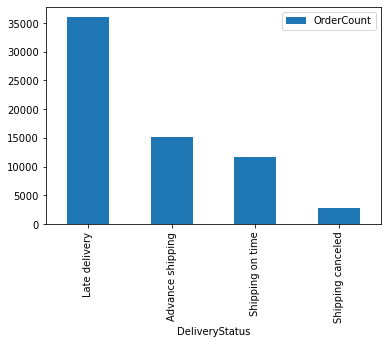

In [19]:
# Điếm số lần xuất hiện của mỗi trạng thái giao hàng (DeliveryStatus)
# và chỉ đếm không tính các giá trị trùng của OrderId (OrderId có thể trùng vì dữ liệu đã được join với chi tiết hóa đơn)
# Một OrderId có thể sẽ xuất hiện nhiều lần
# Sau đó gom kết quả trả vê rồi sắp xếp theo OrderCount là biến đếm
# Plot Bar với trục tung là DeliveryStatus và trục y là OrderCount
spark.sql("""
    Select DeliveryStatus, count(distinct OrderId) as OrderCount
    from orders
    group by DeliveryStatus
    order by OrderCount desc
""").toPandas().plot.bar(x='DeliveryStatus',y='OrderCount')

### 30 Khách hàng (CustomerId) có số lượng đơn cao nhất

<AxesSubplot:xlabel='CustomerId'>

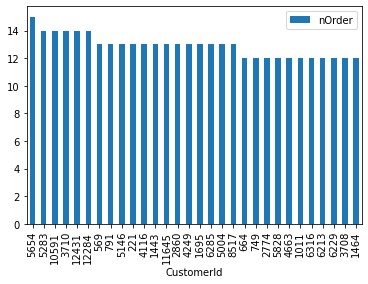

In [20]:
# Tương tự như trên nhưng chỉ lấy 30 dòng có giá trị nOrder cao nhất
spark.sql("""
        Select CustomerFname, CustomerId, count(distinct OrderId) as nOrder
        from orders
        group by CustomerFname,CustomerId
        order by nOrder desc
        limit 30
    """).toPandas().plot.bar(x='CustomerId',y='nOrder' )

### Phân chia theo vùng của các danh mục khách hàng (CustomerSegment) theo số lượng đơn

<AxesSubplot:ylabel='nCount'>

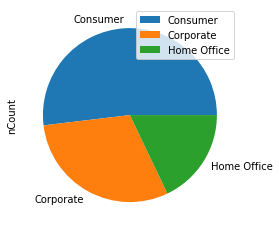

In [21]:
# Piechart plot theo index của PysparkPandas DataFrame chứ không theo x 
# nên ta phải set index và chỉ định y là giá trị số để plot
segment_plot_data = spark.sql("""
        Select CustomerSegment, count(distinct OrderId) as nCount
        from orders
        group by CustomerSegment
        order by nCount desc""").toPandas()
segment_plot_data.index = segment_plot_data.CustomerSegment
segment_plot_data.plot.pie(y='nCount')

### Top 30 danh mục sản phẩm theo số lượng đơn đặt

<AxesSubplot:ylabel='CategoryName'>

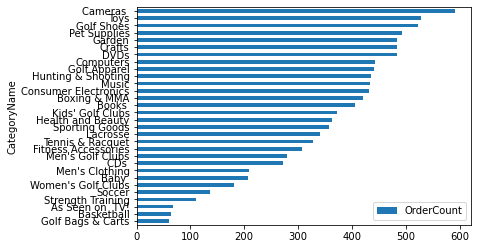

In [22]:
spark.sql("""
    Select CategoryName, count(distinct OrderId) as OrderCount
    from orders
    group by CategoryName
    order by OrderCount asc
    limit 30
    """).toPandas().plot.barh(x='CategoryName',y='OrderCount')

### Top 30 khu vực giao (OrderRegion) theo số lượng đơn

<AxesSubplot:ylabel='OrderRegion'>

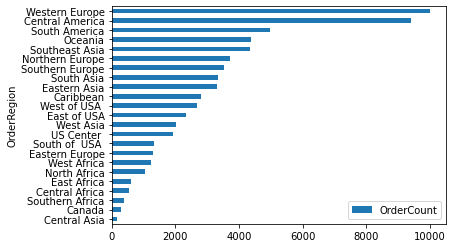

In [23]:
spark.sql("""
    Select OrderRegion, count(distinct OrderId) as OrderCount
    from orders
    group by OrderRegion
    order by OrderCount asc
    """).toPandas().plot.barh(x='OrderRegion',y='OrderCount')

### Top 30 nước đặt hàng theo số lượng đơn

<AxesSubplot:ylabel='OrderCountry'>

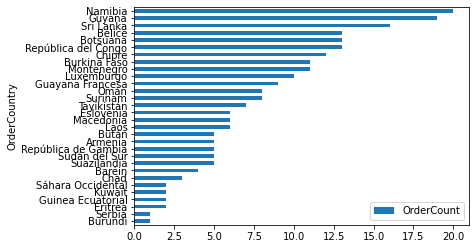

In [24]:
spark.sql("""
    Select OrderCountry, count(OrderId) as OrderCount
    from orders
    group by OrderCountry
    order by OrderCount asc
    limit 30
    """).toPandas().plot.barh(x='OrderCountry',y='OrderCount')

## 2. Phân tích theo doanh số

### Top 30 nước đặt hàng có doanh thu cao nhất

<AxesSubplot:ylabel='OrderCountry'>

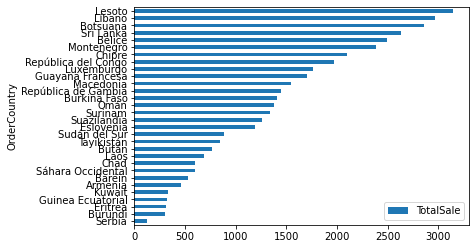

In [25]:
#Top 30 doanh thu theo nuoc dat hang (OrderCountry)
spark.sql("""
    Select OrderCountry, sum(Sales) as TotalSale
    from orders
    group by OrderCountry
    order by TotalSale asc
    limit 30
""").toPandas().plot.barh(x="OrderCountry",y="TotalSale")

### Top 30 loại sản phẩm có doanh thu cao nhất

<AxesSubplot:ylabel='ProductName'>

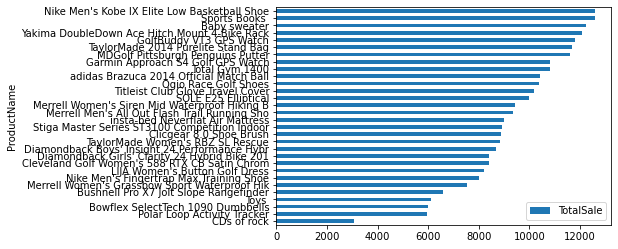

In [26]:
spark.sql("""
    Select ProductName, sum(Sales) as TotalSale
    from orders
    group by ProductName
    order by TotalSale asc
    limit 30
    """).toPandas().plot.barh(x='ProductName',y='TotalSale')

## 3. Phân tích theo tình trạng giao hàng

### Sự phân bố đơn theo ngày giao hàng trong thực tế (Daysforshipping_real_)

<AxesSubplot:xlabel='Daysforshipping_real_'>

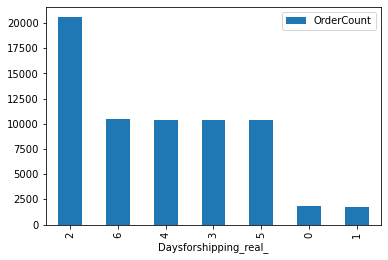

In [27]:
spark.sql(
    """
    Select Daysforshipping_real_, count(distinct OrderId) as OrderCount
    from orders
    group by Daysforshipping_real_
    order by OrderCount desc
    """
).toPandas().plot.bar(x="Daysforshipping_real_",y="OrderCount")

### Sự phân bố đơn theo ngày giao hàng dự tính (Daysforshipment_scheduled_)

<AxesSubplot:xlabel='Daysforshipment_scheduled_'>

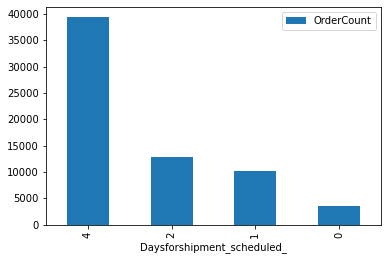

In [28]:
spark.sql(
    """
    Select Daysforshipment_scheduled_, count(distinct OrderId) as OrderCount
    from orders
    group by Daysforshipment_scheduled_
    order by OrderCount desc
    """
).toPandas().plot.bar(x="Daysforshipment_scheduled_",y="OrderCount")

### Sự phân bố đơn theo năm đặt hàng (order_year)

<AxesSubplot:ylabel='order_year'>

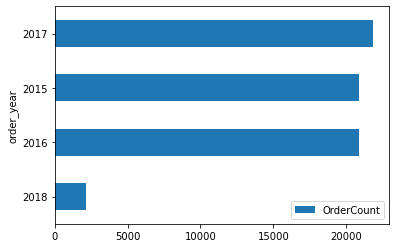

In [29]:
spark.sql("""select order_year,count(distinct OrderId) as OrderCount
        from orders
        group by order_year
        order by OrderCount asc""").toPandas().plot.barh(x='order_year',y='OrderCount')

### Sự phân bố đơn theo tháng đặt hàng trong năm (order_month)

<AxesSubplot:ylabel='order_month'>

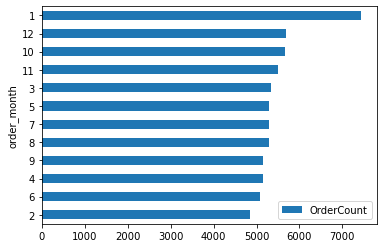

In [30]:
spark.sql("""select order_month,count(distinct OrderId) as OrderCount
        from orders
        group by order_month
        order by OrderCount asc""").toPandas().plot.barh(x='order_month',y='OrderCount')

### Sự phân bố đơn theo ngày đặt hàng trong tháng (order_day)

<AxesSubplot:ylabel='order_day'>

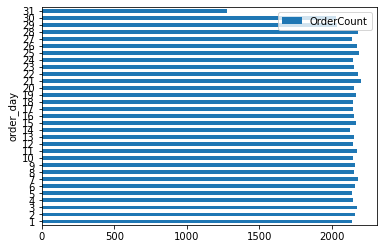

In [31]:
spark.sql("""select order_day,count(distinct OrderId) as OrderCount
        from orders
        group by order_day
        order by order_day asc""").toPandas().plot.barh(x='order_day',y='OrderCount')

### Sự phân bố đơn theo ngày đặt hàng trong tuần

<AxesSubplot:ylabel='order_dow'>

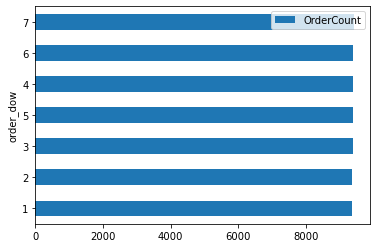

In [32]:
spark.sql("""select order_dow,count(distinct OrderId) as OrderCount
        from orders
        group by order_dow
        order by OrderCount asc""").toPandas().plot.barh(x='order_dow',y='OrderCount')

### Sự phân bố đơn theo giờ đặt hàng trong ngày

<AxesSubplot:ylabel='order_hour'>

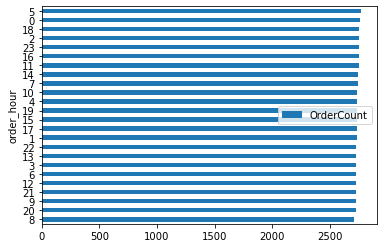

In [33]:
spark.sql("""select order_hour,count(distinct OrderId) as OrderCount
        from orders
        group by order_hour
        order by OrderCount asc""").toPandas().plot.barh(x='order_hour',y='OrderCount')

### Sự phân bố đơn theo tình trạng giao hàng (DeliveryStatus)

<AxesSubplot:ylabel='OrderCount'>

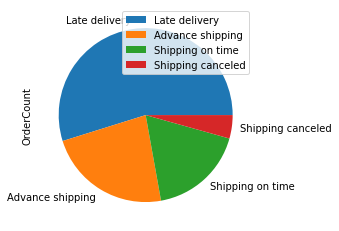

In [34]:
deliveryStatusPlotData = spark.sql("""
    select DeliveryStatus, count(distinct OrderId) as OrderCount
    from orders
    group by DeliveryStatus
    order by OrderCount desc""").toPandas()
deliveryStatusPlotData.index=deliveryStatusPlotData.DeliveryStatus
deliveryStatusPlotData.plot.pie(y='OrderCount')

### Sự phân bố đơn theo nguy cơ giao hàng trễ (Late_delivery_risk)

<AxesSubplot:ylabel='OrderCount'>

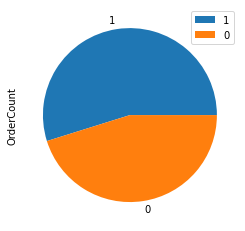

In [35]:
lateDeliveryRiskPlotData = spark.sql("""
    select Late_delivery_risk, count(distinct OrderId) as OrderCount
    from orders
    group by Late_delivery_risk
    order by OrderCount desc""").toPandas()
lateDeliveryRiskPlotData.index=lateDeliveryRiskPlotData.Late_delivery_risk
lateDeliveryRiskPlotData.plot.pie(y='OrderCount')

### Sự phân bố đơn theo chế độ giao hàng (ShippingMode)

<AxesSubplot:ylabel='OrderCount'>

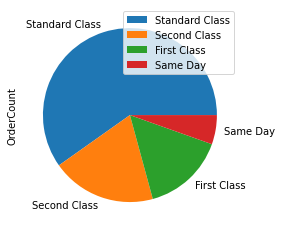

In [36]:
shippinhModePlotData = spark.sql("""
    select ShippingMode, count(distinct OrderId) as OrderCount
    from orders
    group by ShippingMode
    order by OrderCount desc""").toPandas()
shippinhModePlotData.index=shippinhModePlotData.ShippingMode
shippinhModePlotData.plot.pie(y='OrderCount')

## 4. Mô tả các cột dữ liệu số

In [37]:
spark.sql("""
    Select 
    Daysforshipping_real_,
    Daysforshipment_scheduled_,
    Benefitperorder,
    Salespercustomer,
    Late_delivery_risk,
    Latitude,
    Longitude,
    OrderItemDiscount,
    OrderItemDiscountRate,
    OrderItemProfitRatio,
    OrderItemQuantity,
    Sales,
    OrderItemTotal,
    OrderProfitPerOrder,
    ProductPrice
    from orders
""").describe().show()

+-------+---------------------+--------------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|Daysforshipping_real_|Daysforshipment_scheduled_|   Benefitperorder|  Salespercustomer|Late_delivery_risk|         Latitude|         Longitude| OrderItemDiscount|OrderItemDiscountRate|OrderItemProfitRatio| OrderItemQuantity|             Sales|    OrderItemTotal|OrderProfitPerOrder|      ProductPrice|
+-------+---------------------+--------------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|               180519|                    180519|         

# Mã hóa các biến phân loại

## 1. Danh sách các biến phân loại

In [38]:
columnList = [item[0] for item in df.dtypes if item[1].startswith('string')]
print(columnList)

['Type', 'DeliveryStatus', 'CategoryName', 'CustomerCity', 'CustomerCountry', 'CustomerFname', 'CustomerLname', 'CustomerSegment', 'CustomerState', 'CustomerStreet', 'DepartmentName', 'Market', 'OrderCity', 'OrderCountry', 'orderdate_DateOrders_', 'OrderRegion', 'OrderState', 'OrderStatus', 'ProductName', 'shippingdate_DateOrders_', 'ShippingMode', 'CustomerStreetName']


## 2. Mã hóa các biến phân loại

In [39]:
#Tạo dict dùng để mã hóa
encoder = dict()

In [40]:
for c in columnList:
    # Các cột CustomerFname, CustomerLName không có giá trị phân tích
    # Cột DepartmentName, ProductName đã có giá trị ID thay thế tương ứng
    # Cột CustomerStreet (thành CustomerStreetName, bỏ số nhà), 
    # orderdate_DateOrders_ và shippingdate_DateOrders_ đã được xử lý
    if ( c in ['CustomerFname','CustomerStreet','DepartmentName', 'CustomerLname','CategoryName','ProductName','orderdate_DateOrders_','shippingdate_DateOrders_'] ):
        continue
    # Đối với mỗi cột nằm trong danh sách các thuộc tính phân loại (columnList), 
    # thay thế tên cột vào query, query đếm số lần xuất hiện, sắp xếp theo tên biến phân loại tăng dần,
    # Nhóm theo biến phân loại
    temp_df = spark.sql(f"""
    Select {c}, count(*) as occurence 
    from orders 
    group by {c} 
    order by {c} asc""")
    temp_df.show()
    # Lấy kết quả trả về (là một chuỗi gồm danh sách các biến phân loại 
    # đã được sắp xếp như các Dataframe được hiện ra bên dưới)
    temp_rows = temp_df.collect()
    temp_output = list()
    # Đọc qua từng dòng trong kết quả trả về của DataFrame.collect(). 
    # Mỗi dòng sẽ gồm 2 phần tử là [Thuộc tính phân loại, số lần xuất hiện], 
    # ta lấy phần tử thứ nhất thêm vào mảng output tạm
    for r in temp_rows:
        temp_output.append(r[0])
    # Thêm { tên cột: Mảng output tạm } vào dict
    encoder[c] = temp_output

+--------+---------+
|    Type|occurence|
+--------+---------+
|    CASH|    19616|
|   DEBIT|    69295|
| PAYMENT|    41725|
|TRANSFER|    49883|
+--------+---------+

+-----------------+---------+
|   DeliveryStatus|occurence|
+-----------------+---------+
| Advance shipping|    41592|
|    Late delivery|    98977|
|Shipping canceled|     7754|
| Shipping on time|    32196|
+-----------------+---------+

+-----------------+---------+
|     CustomerCity|occurence|
+-----------------+---------+
|        Aguadilla|       50|
|          Alameda|      118|
|           Albany|       71|
|      Albuquerque|      552|
|        Algonquin|      128|
|         Alhambra|      117|
|        Allentown|       50|
|       Alpharetta|      106|
|         Amarillo|      292|
|          Anaheim|      331|
|        Ann Arbor|      185|
|        Annandale|      104|
|        Annapolis|       93|
|          Antioch|      347|
|             Apex|      240|
|           Apopka|      125|
|          Arecibo| 

In [41]:
# Kiểm tra các khóa trong dict
print(encoder.keys())

dict_keys(['Type', 'DeliveryStatus', 'CustomerCity', 'CustomerCountry', 'CustomerSegment', 'CustomerState', 'Market', 'OrderCity', 'OrderCountry', 'OrderRegion', 'OrderState', 'OrderStatus', 'ShippingMode', 'CustomerStreetName'])


In [42]:
print(encoder['Type'])
# Ví dụ sử dụng dict để mã hóa thuộc giá trị "DEBIT" của thuộc tính "Type"
temp = encoder['Type'].index('DEBIT')
print(temp)
# Để giải mã giá trị DEBIT của thuộc tính Type
print(encoder['Type'][temp])

['CASH', 'DEBIT', 'PAYMENT', 'TRANSFER']
1
DEBIT


In [43]:
from pyspark.sql.types import *
# Bên cạnh các hàm hỗ trợ trong pysparks.sql.functions ta có thể định nghĩa 
# các hàm thủ công udf (UserDefinedFunction)
# Hàm này nhận 3 tham số cho hàm khởi tạo là udf(hàm xử lý, kiểu trả về)
# Các kiểu trả về có thể tham khảo thêm ở pyspark.sql.types
# Bên cạnh cách sử dụng lambda như bên dưới có thể sử dụng hàm xử lý như

# def typeEncoder (x):
#     return encoder['Type'].index(x)
# udf_type = udf(typeEncoder,IntegerType())

# Các hàm lambda này nhận vào x và trả về nơi x được tìm thấy bên trong encoder[Cột tương ứng]

udf_type = udf(lambda x: encoder['Type'].index(x),IntegerType())
udf_delivery = udf(lambda x: encoder['DeliveryStatus'].index(x),IntegerType())
udf_cCity = udf(lambda x:encoder['CustomerCity'].index(x),IntegerType())
udf_cCountry = udf(lambda x:encoder['CustomerCountry'].index(x),IntegerType())
udf_cSegment = udf(lambda x:encoder['CustomerSegment'].index(x),IntegerType())
udf_cState = udf(lambda x:encoder['CustomerState'].index(x),IntegerType())
udf_market = udf(lambda x:encoder['Market'].index(x),IntegerType())
udf_oCity = udf(lambda x:encoder['OrderCity'].index(x),IntegerType())
udf_oCountry = udf(lambda x:encoder['OrderCountry'].index(x),IntegerType())
udf_oRegion = udf(lambda x:encoder['OrderRegion'].index(x),IntegerType())
udf_oState = udf(lambda x:encoder['OrderState'].index(x),IntegerType())
udf_oStatus = udf(lambda x:encoder['OrderStatus'].index(x),IntegerType())
udf_oMode = udf(lambda x:encoder['ShippingMode'].index(x),IntegerType())
udf_OSName = udf(lambda x:encoder['CustomerStreetName'].index(x),IntegerType())

df_selectedFeatures = df.drop('CustomerFname','CustomerStreet','DepartmentName', 'CustomerLname','CategoryName',
                               'ProductName','orderdate_DateOrders_','shippingdate_DateOrders_')
# Lấy tất cả các dòng, áp dụng encoder tương ứng với thuộc tính cho các thuộc tính sẽ được mã hóa và thêm mới một cột mới là encoded + Tên cột sau cột cuối cùng của mỗi dòng
df_selectedFeatures = df_selectedFeatures.select(
    "*",
    udf_type(df_selectedFeatures.Type).alias('encodedType'),
    udf_delivery(df_selectedFeatures.DeliveryStatus).alias('encodedDeliveryStatus'),
    udf_cCity(df_selectedFeatures.CustomerCity).alias('encodedCustomerCity'),
    udf_cCountry(df_selectedFeatures.CustomerCountry).alias('encodedCustomerCountry'),
    udf_cSegment(df_selectedFeatures.CustomerSegment).alias('encodedCustomerSegment'),
    udf_cState(df_selectedFeatures.CustomerState).alias('encodedCustomerState'),
    udf_market(df_selectedFeatures.Market).alias('encodedMarket'),
    udf_oCity(df_selectedFeatures.OrderCity).alias('encodedOrderCity'),
    udf_oCountry(df_selectedFeatures.OrderCountry).alias('encodedOrderCountry'),
    udf_oRegion(df_selectedFeatures.OrderRegion).alias('encodedOrderRegion'),
    udf_oState(df_selectedFeatures.OrderState).alias('encodedOrderState'),
    udf_oStatus(df_selectedFeatures.OrderStatus).alias('encodedOrderStatus'),
    udf_oMode(df_selectedFeatures.ShippingMode).alias('encodedShippingMode'),
    udf_OSName(df_selectedFeatures.CustomerStreetName).alias('encodedCustomerStreetName')
).drop('Type','DeliveryStatus','CustomerCity','CustomerCountry','CustomerSegment','CustomerState','Market'
       ,'OrderCity','OrderRegion','OrderState','ShippingMode','CustomerStreetName','OrderCountry','OrderStatus')

In [44]:
# Mô tả của các cột sau khi được mã hóa
df_selectedFeatures.describe().show()

23/12/21 04:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/21 04:07:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


+-------+---------------------+--------------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+---------------------+--------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-------------------+----------------------+----------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------------+
|summary|Daysforshipping_real_|Daysforshipment_scheduled_|   Be

# Cài đặt mô hình

## Xác định hệ số tương quan giữa các cột so với y là Daysforshipping_real_

### Tính tổng, tổng tích y, và tổng các bình phương của mỗi cột

In [45]:
columnsList = df_selectedFeatures.columns
print("Các cột được xét")
columnsList

Các cột được xét


['Daysforshipping_real_',
 'Daysforshipment_scheduled_',
 'Benefitperorder',
 'Salespercustomer',
 'Late_delivery_risk',
 'CategoryId',
 'CustomerId',
 'CustomerZipcode',
 'DepartmentId',
 'Latitude',
 'Longitude',
 'OrderId',
 'OrderItemDiscount',
 'OrderItemDiscountRate',
 'OrderItemProfitRatio',
 'OrderItemQuantity',
 'Sales',
 'OrderItemTotal',
 'OrderProfitPerOrder',
 'ProductCardId',
 'ProductPrice',
 'order_year',
 'order_month',
 'order_day',
 'order_hour',
 'order_minute',
 'order_dow',
 'ship_year',
 'ship_month',
 'ship_day',
 'ship_hour',
 'ship_minute',
 'ship_dow',
 'encodedType',
 'encodedDeliveryStatus',
 'encodedCustomerCity',
 'encodedCustomerCountry',
 'encodedCustomerSegment',
 'encodedCustomerState',
 'encodedMarket',
 'encodedOrderCity',
 'encodedOrderCountry',
 'encodedOrderRegion',
 'encodedOrderState',
 'encodedOrderStatus',
 'encodedShippingMode',
 'encodedCustomerStreetName']

In [46]:
from decimal import Decimal
n = df_selectedFeatures.count()
sums = list()
for i in range(len(columnsList)):
    standardized = df_selectedFeatures.select(
        (sum(col(columnsList[i]))).alias('vSum'), # Tính tổng cột
        # Nhân mỗi phần tử với y rồi tính tổng của các tích này
        (sum(col(columnsList[i])*col(columnsList[0]))).alias('vSumY'), 
        (sum(pow(col(columnsList[i]),2))).alias('vSum2'), # Bình phương mỗi phần tử rồi tính tổng của nó
    ).collect()[0]
    # Chuyển giá trị trả về sang mã gồm 3 phần tử [Tổng, Tổng tích y, Tổng của các bình phương]
    standardized = [standardized[i] for i in range(len(standardized))] 
    sums.append(standardized) # Thêm mảng 3 chiều trên vào mảng chứa sums
    print(standardized)


[631393, 2684325, 2684325.0]
[529254, 2058978, 1892710.0]
[3966902.974050192, 13718700.352976091, 2055967176.9289484]
[33054402.380214702, 115674674.16924083, 8653864089.029078]
[98977, 404742, 98977.0]
[5749792, 20109189, 227296012.0]
[1207921135, 4229077516, 11211015283375.0]
[6484338146, 22681226517, 487349142916242.0]
[982648, 3436184, 5828180.0]
[5365016.495642864, 18753254.51055541, 176833312.13806245]
[-15328892.678974783, -53590594.409079134, 1384590313.978568]
[6538740246, 22859698026, 316798428548968.0]
[3730378.40259241, 13061831.129248863, 162883769.48019052]
[18353.040090263756, 64222.86031715826, 2760.9832367061317]
[21779.00999206888, 75540.85997914417, 41962.1000811003]
[384079, 1343030, 1198529.0]
[36784735.01337469, 128736343.63214147, 10654075637.793993]
[33054402.380214702, 115674674.16924083, 8653864089.029078]
[3966902.974050192, 13718700.352976091, 2055967176.9289484]
[125011170, 437161132, 107005453286.0]
[25495158.68058428, 89262751.12538402, 7125390786.886689]


[Stage 474:============================>                            (2 + 2) / 4]



[302394, 1059085, 685142.0]
[211073, 746028, 419757.0]
[35018273, 122350936, 11468243101.0]
[69373, 243047, 69373.0]
[119241, 417522, 183693.0]
[4720960, 16532577, 154208870.0]
[380416, 1330203, 1040752.0]


[333439190, 1167200434, 798047484118.0]
[11760023, 41156642, 1082320269.0]
[2189511, 7650378, 35359621.0]



[Stage 504:==============>                                          (1 + 3) / 4]



[99457856, 348267261, 71841823310.0]
[701519, 2459294, 3648897.0]
[403425, 1577440, 1120369.0]


[615139290, 2149531403, 2781486088212.0]



[Stage 513:==========================================>              (3 + 1) / 4]



### Tính hệ số tương quan từ các tổng

In [47]:
import math
corrs = list()
for i in range(len(columnsList)):
    # Đối với mỗi cột 
    # (n*tổng tich y - tổng*tổng của y) 
    # / căn bậc hai của ( [n*tổng các bình phương - tổng ^ 2] * [n* tổng các bình phương của y - tổng của y ^ 2] ) 
    correlation = (n*sums[i][1] - sums[i][0]*sums[0][0]) / math.sqrt(
        (n*sums[i][2]-sums[i][0]**2)*(n*sums[0][2]-sums[0][0]**2)
    )
    print("Correlation coefficient for " + columnsList[i] + ": " + str(correlation))
    corrs.append([columnsList[i],abs(correlation)])

Correlation coefficient for Daysforshipping_real_: 1.0
Correlation coefficient for Daysforshipment_scheduled_: 0.5158800202898423
Correlation coefficient for Benefitperorder: -0.005101290470769714
Correlation coefficient for Salespercustomer: 0.0017567127837178943
Correlation coefficient for Late_delivery_risk: 0.4014149301115186
Correlation coefficient for CategoryId: -0.00034769089672669117
Correlation coefficient for CustomerId: 0.0034316935444800075
Correlation coefficient for CustomerZipcode: 0.00011408023310938239
Correlation coefficient for DepartmentId: -0.0016306033873486703
Correlation coefficient for Latitude: -0.0040733088348721535
Correlation coefficient for Longitude: 0.003910686262360169
Correlation coefficient for OrderId: -0.0017107296183225074
Correlation coefficient for OrderItemDiscount: 0.0022313067373652506
Correlation coefficient for OrderItemDiscountRate: 0.0014669210035811648
Correlation coefficient for OrderItemProfitRatio: -0.004637973492743132
Correlation co

### Vẽ các hệ số tương quan ra trên biểu đồ để so sánh

<AxesSubplot:ylabel='Attribute'>

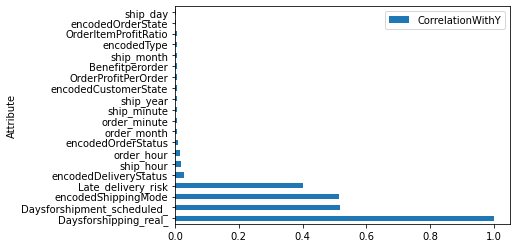

In [48]:
# Tạo Spark DataFrame mới với data là mảng gồm [cột 1, hệ số tương quan của cột 1 so với y], [cột 2, hệ số tương quan của cột 2 so với y], ... 
# Đặt tên cột là thuộc tính (Attribute) và hệ số tương quan (CorelationWithY) (schema=['Attribute','CorrelationWithY']) sau đó sắp xếp theo CorrelationWithY giảm dần (ascending = False)
# Và chỉ lấy 20 dòng có giá trị cao nhất (limit(20))
plot_data = spark.createDataFrame(data=corrs,schema=['Attribute','CorrelationWithY']).sort('CorrelationWithY',ascending=False).limit(20)
# Hàm plot như trên
plot_data.toPandas().plot.barh(y='CorrelationWithY',x='Attribute')

### Kết luận và xử lý

In [49]:
# Từ biểu đồ 7 cột mang giá trị cao nhất là  
# Daysforshipment_scheduled_, encodedShippingMode, Late_delivery_risk, 
# encodedDeliveryStatus, order_hour, encodedOrderStatus, ship_hour
# Tuy nhiên ta không lấy cột ship_hour vì ship_hour chỉ được xác định sau khi giao hàng
# Từ đó ta có dataframe để phục vụ huấn luyện và đánh giá mô hình
df_modelData = df_selectedFeatures.select('Daysforshipping_real_','Daysforshipment_scheduled_',
                                            'encodedShippingMode','Late_delivery_risk',
                                            'encodedDeliveryStatus','order_hour',
                                            'encodedOrderStatus')
nDatapoint = df_modelData.count() # Đếm số dòng dữ liệu
print('Training/ evaluating on ' + str(nDatapoint) + " datapoints")
df_modelData.show()

Training/ evaluating on 180519 datapoints
+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+
|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode|Late_delivery_risk|encodedDeliveryStatus|order_hour|encodedOrderStatus|
+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+
|                    3|                         4|                  3|                 0|                    0|        22|                 2|
|                    5|                         4|                  3|                 1|                    1|        12|                 5|
|                    4|                         4|                  3|                 0|                    3|        12|                 1|
|                    3|                         4|                  3|                 0|                 

## Phân tích dữ liệu tổng, train và test

### Chia dữ liệu tổng ra hai tập train và test với mức chia 7-3, hạt ngẫu nhiên là 2

In [50]:
df_train, df_test = df_modelData.randomSplit([0.7,0.3],seed= 2)
df_train.show()
df_test.show()

+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+
|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode|Late_delivery_risk|encodedDeliveryStatus|order_hour|encodedOrderStatus|
+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+
|                    0|                         0|                  1|                 0|                    2|         1|                 8|
|                    0|                         0|                  1|                 0|                    2|         1|                 8|
|                    0|                         0|                  1|                 0|                    2|         1|                 8|
|                    0|                         0|                  1|                 0|                    2|         2|                 8|
|     

###  Phân tích dữ liệu tổng

In [51]:
df_modelData.createOrReplaceTempView('plotting')
df_modelData.describe().show()


[Stage 523:==============>                                          (1 + 3) / 4]



+-------+---------------------+--------------------------+-------------------+------------------+---------------------+------------------+------------------+
|summary|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode|Late_delivery_risk|encodedDeliveryStatus|        order_hour|encodedOrderStatus|
+-------+---------------------+--------------------------+-------------------+------------------+---------------------+------------------+------------------+
|  count|               180519|                    180519|             180519|            180519|               180519|            180519|            180519|
|   mean|   3.4976539865609713|         2.931846509231715|  2.234806308477224|0.5482913155955883|   1.1692564217616983|11.483688697588619|3.8861227903987947|
| stddev|   1.6237218283741663|        1.3744492800079782|  1.100919908874379|0.4976638632880924|   0.9788378350333965| 6.923005534869744|2.2608507458783293|
|    min|                    0|                     

<AxesSubplot:xlabel='Daysforshipment_scheduled_'>

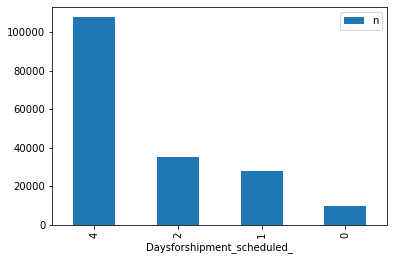

In [52]:
spark.sql("""
        Select Daysforshipment_scheduled_, count(*) as n
        from plotting
        group by Daysforshipment_scheduled_
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Daysforshipment_scheduled_',y='n')

0: First Class
1: Same Day
2: Second Class
3: Standard Class


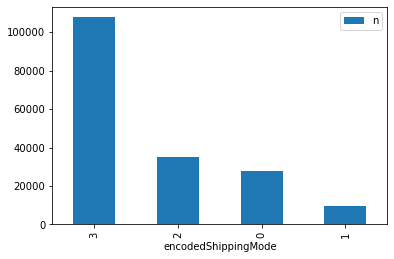

In [53]:
spark.sql("""
        Select encodedShippingMode, count(*) as n
        from plotting
        group by encodedShippingMode
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedShippingMode',y='n')
for i in range(len(encoder['ShippingMode'])):
    print (str(i) + ": " + encoder['ShippingMode'][i])

<AxesSubplot:xlabel='Late_delivery_risk'>

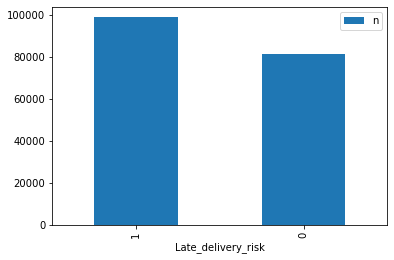

In [54]:
spark.sql("""
        Select Late_delivery_risk, count(*) as n
        from plotting
        group by Late_delivery_risk
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Late_delivery_risk',y='n')

0: Advance shipping
1: Late delivery
2: Shipping canceled
3: Shipping on time


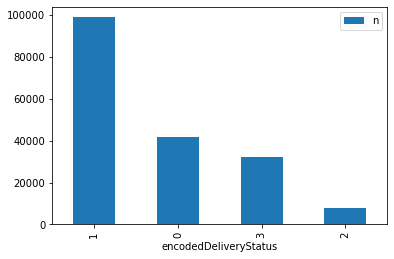

In [55]:
spark.sql("""
        Select encodedDeliveryStatus, count(*) as n
        from plotting
        group by encodedDeliveryStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedDeliveryStatus',y='n')
for i in range(len(encoder['DeliveryStatus'])):
    print (str(i) + ": " + encoder['DeliveryStatus'][i])

<AxesSubplot:xlabel='order_hour'>

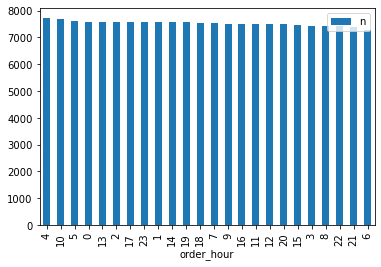

In [56]:
spark.sql("""
        Select order_hour, count(*) as n
        from plotting
        group by order_hour
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='order_hour',y='n')

0: CANCELED
1: CLOSED
2: COMPLETE
3: ON_HOLD
4: PAYMENT_REVIEW
5: PENDING
6: PENDING_PAYMENT
7: PROCESSING
8: SUSPECTED_FRAUD


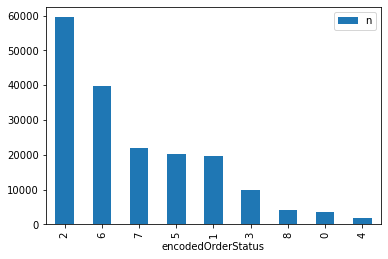

In [57]:
spark.sql("""
        Select encodedOrderStatus, count(*) as n
        from plotting
        group by encodedOrderStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedOrderStatus',y='n')
for i in range(len(encoder['OrderStatus'])):
    print (str(i) + ": " + encoder['OrderStatus'][i])

### Phân tích dữ liệu train

In [58]:
df_train.createOrReplaceTempView('plotting')
df_train.describe().show()

+-------+---------------------+--------------------------+-------------------+------------------+---------------------+------------------+------------------+
|summary|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode|Late_delivery_risk|encodedDeliveryStatus|        order_hour|encodedOrderStatus|
+-------+---------------------+--------------------------+-------------------+------------------+---------------------+------------------+------------------+
|  count|               126509|                    126509|             126509|            126509|               126509|            126509|            126509|
|   mean|    3.497427060525338|        2.9315937996506176| 2.2336276470448744|0.5490360369617971|   1.1670869266218213|11.478795974989922|3.8843797674473755|
| stddev|   1.6226493453219213|        1.3740362312270282|  1.102183183134319|0.4975916239565622|   0.9777867562955087|  6.92480832424922| 2.260303507345705|
|    min|                    0|                     


[Stage 544:============================>                            (2 + 2) / 4]



<AxesSubplot:xlabel='Daysforshipment_scheduled_'>

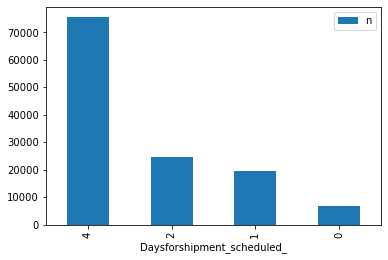

In [59]:
spark.sql("""
        Select Daysforshipment_scheduled_, count(*) as n
        from plotting
        group by Daysforshipment_scheduled_
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Daysforshipment_scheduled_',y='n')


[Stage 550:============================>                            (2 + 2) / 4]



<AxesSubplot:xlabel='Late_delivery_risk'>

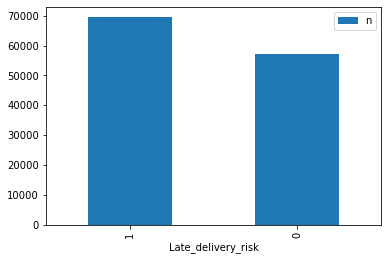

In [60]:
spark.sql("""
        Select Late_delivery_risk, count(*) as n
        from plotting
        group by Late_delivery_risk
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Late_delivery_risk',y='n')

0: First Class
1: Same Day
2: Second Class
3: Standard Class


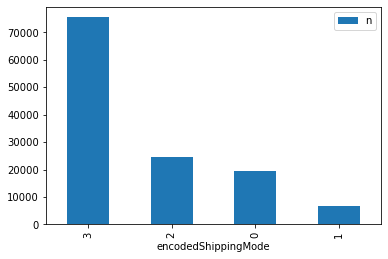

In [61]:
spark.sql("""
        Select encodedShippingMode, count(*) as n
        from plotting
        group by encodedShippingMode
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedShippingMode',y='n')
for i in range(len(encoder['ShippingMode'])):
    print (str(i) + ": " + encoder['ShippingMode'][i])


[Stage 556:>                                                        (0 + 4) / 4]



0: Advance shipping
1: Late delivery
2: Shipping canceled
3: Shipping on time


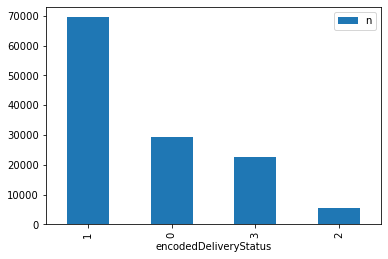

In [62]:
spark.sql("""
        Select encodedDeliveryStatus, count(*) as n
        from plotting
        group by encodedDeliveryStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedDeliveryStatus',y='n')
for i in range(len(encoder['DeliveryStatus'])):
    print (str(i) + ": " + encoder['DeliveryStatus'][i])

<AxesSubplot:xlabel='order_hour'>

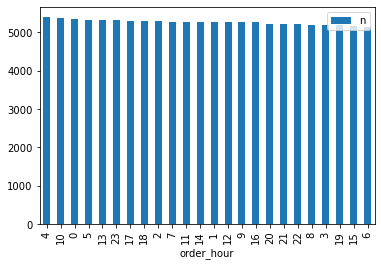

In [63]:
spark.sql("""
        Select order_hour, count(*) as n
        from plotting
        group by order_hour
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='order_hour',y='n')


[Stage 562:==============>                                          (1 + 3) / 4]



0: CANCELED
1: CLOSED
2: COMPLETE
3: ON_HOLD
4: PAYMENT_REVIEW
5: PENDING
6: PENDING_PAYMENT
7: PROCESSING
8: SUSPECTED_FRAUD


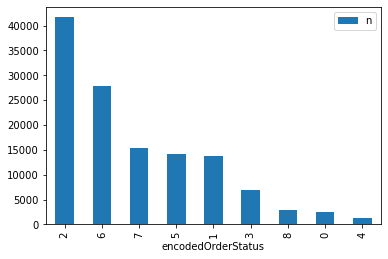

In [64]:
spark.sql("""
        Select encodedOrderStatus, count(*) as n
        from plotting
        group by encodedOrderStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedOrderStatus',y='n')
for i in range(len(encoder['OrderStatus'])):
    print (str(i) + ": " + encoder['OrderStatus'][i])

### Phân tích dữ liệu test

In [65]:
df_test.createOrReplaceTempView('plotting')
df_test.describe().show()

+-------+---------------------+--------------------------+-------------------+-------------------+---------------------+------------------+------------------+
|summary|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode| Late_delivery_risk|encodedDeliveryStatus|        order_hour|encodedOrderStatus|
+-------+---------------------+--------------------------+-------------------+-------------------+---------------------+------------------+------------------+
|  count|                54010|                     54010|              54010|              54010|                54010|             54010|             54010|
|   mean|    3.498185521199778|         2.932438437326421| 2.2375671172005185| 0.5465469357526384|    1.174338085539715|11.495149046472875|  3.89020551749676|
| stddev|   1.6262460754892987|         1.375428832909498| 1.0979604548700475|0.49783327682502115|    0.981285686231721| 6.918831517949968| 2.262147713143219|
|    min|                    0|               


[Stage 565:>                                                        (0 + 4) / 4]




[Stage 568:============================>                            (2 + 2) / 4]



<AxesSubplot:xlabel='Daysforshipment_scheduled_'>

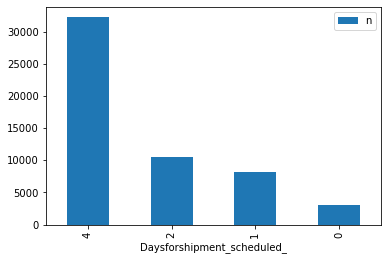

In [66]:
spark.sql("""
        Select Daysforshipment_scheduled_, count(*) as n
        from plotting
        group by Daysforshipment_scheduled_
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Daysforshipment_scheduled_',y='n')


[Stage 571:==============>                                          (1 + 3) / 4]



<AxesSubplot:xlabel='Late_delivery_risk'>

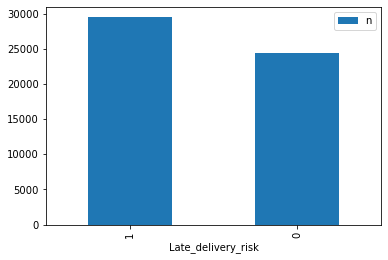

In [67]:
spark.sql("""
        Select Late_delivery_risk, count(*) as n
        from plotting
        group by Late_delivery_risk
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='Late_delivery_risk',y='n')

0: First Class
1: Same Day
2: Second Class
3: Standard Class



[Stage 574:==========================================>              (3 + 1) / 4]



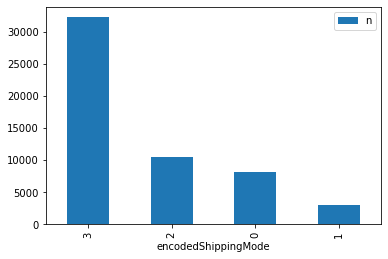

In [68]:
spark.sql("""
        Select encodedShippingMode, count(*) as n
        from plotting
        group by encodedShippingMode
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedShippingMode',y='n')
for i in range(len(encoder['ShippingMode'])):
    print (str(i) + ": " + encoder['ShippingMode'][i])

0: Advance shipping
1: Late delivery
2: Shipping canceled
3: Shipping on time


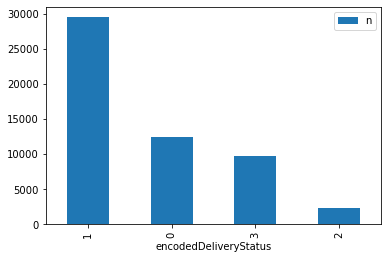

In [69]:
spark.sql("""
        Select encodedDeliveryStatus, count(*) as n
        from plotting
        group by encodedDeliveryStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedDeliveryStatus',y='n')
for i in range(len(encoder['DeliveryStatus'])):
    print (str(i) + ": " + encoder['DeliveryStatus'][i])


[Stage 580:==============>                                          (1 + 3) / 4]



<AxesSubplot:xlabel='order_hour'>

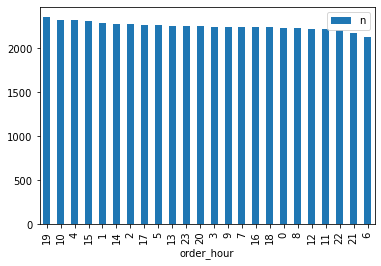

In [70]:
spark.sql("""
        Select order_hour, count(*) as n
        from plotting
        group by order_hour
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='order_hour',y='n')


[Stage 583:>                                                        (0 + 4) / 4]



0: CANCELED
1: CLOSED
2: COMPLETE
3: ON_HOLD
4: PAYMENT_REVIEW
5: PENDING
6: PENDING_PAYMENT
7: PROCESSING
8: SUSPECTED_FRAUD


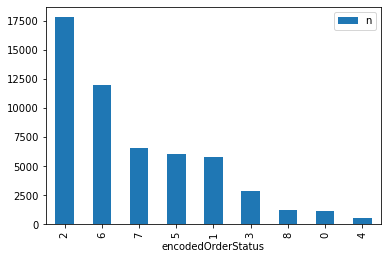

In [71]:
spark.sql("""
        Select encodedOrderStatus, count(*) as n
        from plotting
        group by encodedOrderStatus
        order by n desc
        limit 30
        """).toPandas().plot.bar(x='encodedOrderStatus',y='n')
for i in range(len(encoder['OrderStatus'])):
    print (str(i) + ": " + encoder['OrderStatus'][i])

## Cài đặt các hàm hỗ trợ tính toán mô hình

In [72]:
# Mỗi cột sẽ có một reg, reg được bằng tổng các bình phương - tổng ^ 2 / số dòng dữ liệu
def calculate_reg(sum, sum_p2, n):
    return sum_p2 - sum*sum/n
# Reg_y được tính bằng tổng của các tích của cột đó với y - tổng cột đó * tổng y / số dòng dữ liệu
def calculate_reg_y (n,sum_y,sum_x,sum_x_y):
    return sum_x_y - sum_x * sum_y / n


# Hàm tính model sử dụng các tổng
# n là số dòng dữ liệu
# sum y là tổng của cột y (Daysforshipping_real_)
# sum_wide là tổng của các tích của toàn bộ các thuộc tính trên dòng dữ liệu đó không tính y
# sums [
#     [tổng cột 1, tổng tích cột 1 với y, tổng các bình phương cột 1 ],
#     [tổng cột 2, tổng tích cột 2 với y, tổng các bình phương cột 2 ],
# ]
def calculateModel(n, sum_y, sum_wide, sums):
    print(n,sum_y,sum_wide,len(sums))
    for sum in sums:
        print(sum)
    # tính các reg tương ứng với các tổng và tổng tích y của các cột (không tính y)
    regs = [calculate_reg(temp_sum[0],temp_sum[1],n) for temp_sum in sums ] 
    # tính các reg_y tương ứng với các tổng và tổng các bình phương của các cột (không tính y)
    regs_y = [calculate_reg_y(n,sum_y,temp_sum[0],temp_sum[2]) for temp_sum in sums ] 
    avgs = [(temp_sum[0]) / (n) for temp_sum in sums] # tính trung vị với tổng của các cột và số dòng dữ liệu
    sums_mul = 1 # Tích các sum
    regs_mul = 1 # Tich các reg
    regs_y_mul = 1 # Tích các reg_y
    for i in range(0,len(sums)):
        regs_mul *= regs[i]
        regs_y_mul *= regs_y[i]
        sums_mul *= sums[i][0]
    reg_all = sum_wide - (sums_mul / n) # Chỉ dùng để hỗ trợ tính toán
    print(reg_all)
    coefs = list()
    for i in range(0,len(sums)):
        # Đối các cột biến phụ thuộc, lấy reg hiện tại, reg_y hiện tại
        # Sau đó hệ số của cột đó sẽ = 
        # ( tích các reg không tính reg hiện tại * reg_y - reg_all * tích các reg_y không tính reg_y hiện tại ) 
        # / ( tích các reg - reg_all^2 )
        reg = regs[i]
        reg_y = regs_y[i]
        coef = ((regs_mul/reg)*reg_y - reg_all * regs_y_mul / reg_y ) / ( regs_mul - reg_all*reg_all )
        coefs.append(coef)
        print("b" + str(i+1) +" =" + str(coef))
    # Hằng số sẽ là tổng y * trung vị y - hằng số cột 1 * trung vị cột 1 - hằng số cột 2 * trung vị cột 2 - ...
    intercept = sum_y / n
    for i in range(0,len(sums)):
        intercept -= coefs[i]*avgs[i]
    print("b0 =" + str(intercept))
    return [intercept] + coefs # return a list of [b0,b1,b2,...]

def processSums(arr):
    # Nhận vào mảng gồm ( 3 + 3 * số cột ) phần tử
    # Chuyển kết quả trả về từ Dataframe sang các tham số hỗ trợ tính toán
    n = Decimal(arr[0]) # Phần tử trả về đầu tiên là count(*)
    sum_y = Decimal(arr[1]) # Phần tử trả về thứ hai là sum(df_train.Daysforshipping_real_)
    sum_wide = Decimal(arr[2]) # Phần tử trả về thứ ba là tổng của các tích giữa các cột
    sums = list()
    for i in range(3,len(arr),3): # Đối với phần tử bắt đầu kể tử phần tử thứ 3, tăng i lên 3 mỗi vòng lặp
         # Thêm mảng gồm [tổng cột, tổng của các tích giữa cột với y, 
         # tổng của các bình phương của cột] vào mảng chứa sums
        sums.append([Decimal(arr[i]),Decimal(arr[i+1]),Decimal(arr[i+2])])
    return (n,sum_y,sum_wide,sums) # Trả về các giá trị hỗ trợ tính toán


## Thực hiện tính toán các tổng

In [73]:
# Sử dụng hàm hỗ trợ sum của pyspark.sql.functions để tích các tổng
data_sums = df_train.select(
    count("*").alias("n"), # Số dòng dữ liệu
    sum(df_train.Daysforshipping_real_).alias("sum_y"), # Tổng y
    sum(
        df_train.Daysforshipment_scheduled_ *
        df_train.order_hour *
        df_train.encodedOrderStatus *
        df_train.Late_delivery_risk *
        df_train.encodedShippingMode *
        df_train.encodedDeliveryStatus
    ).alias("sum_wide"), # Tổng của các tích giữa các cột
    sum(df_train.Daysforshipment_scheduled_).alias("sum_scheduled"), # Tổng cột 1
    # Tổng các tích của cột 1 với y  
    sum(pow(df_train.Daysforshipment_scheduled_,2)).alias("sum_scheduled_p2"), 
    # Tổng các bình phương của cột 1
    sum(df_train.Daysforshipment_scheduled_ * df_train.Daysforshipping_real_).alias("sum_scheduled_y"), 
    sum(df_train.order_hour).alias("sum_hour"),
    sum(pow(df_train.order_hour,2)).alias("sum_hour_p2"),
    sum(df_train.order_hour * df_train.Daysforshipping_real_).alias("sum_hour_y"),
    sum(df_train.encodedOrderStatus).alias("sum_oStatus"),
    sum(pow(df_train.encodedOrderStatus,2)).alias("sum_oStatus_p2"),
    sum(df_train.encodedOrderStatus * df_train.Daysforshipping_real_).alias("sum_oStatus_y"),
    sum(df_train.Late_delivery_risk).alias("sum_risk"),
    sum(pow(df_train.Late_delivery_risk,2)).alias("sum_risk_p2"),
    sum(df_train.Late_delivery_risk * df_train.Daysforshipping_real_).alias("sum_risk_y"),
    sum(df_train.encodedShippingMode).alias("sum_mode"),
    sum(pow(df_train.encodedShippingMode,2)).alias("sum_mode_p2"),
    sum(df_train.encodedShippingMode * df_train.Daysforshipping_real_).alias("sum_mode_y"),
    sum(df_train.encodedDeliveryStatus).alias("sum_dStatus"),
    sum(pow(df_train.encodedDeliveryStatus,2)).alias("sum_dStatus_p2"),
    sum(df_train.encodedDeliveryStatus * df_train.Daysforshipping_real_).alias("sum_dStatus_y"),
)
data_sums.show()

+------+------+--------+-------------+----------------+---------------+--------+-----------+----------+-----------+--------------+-------------+--------+-----------+----------+--------+-----------+----------+-----------+--------------+-------------+
|     n| sum_y|sum_wide|sum_scheduled|sum_scheduled_p2|sum_scheduled_y|sum_hour|sum_hour_p2|sum_hour_y|sum_oStatus|sum_oStatus_p2|sum_oStatus_y|sum_risk|sum_risk_p2|sum_risk_y|sum_mode|sum_mode_p2|sum_mode_y|sum_dStatus|sum_dStatus_p2|sum_dStatus_y|
+------+------+--------+-------------+----------------+---------------+--------+-----------+----------+-----------+--------------+-------------+--------+-----------+----------+--------+-----------+----------+-----------+--------------+-------------+
|126509|442456|18582940|       370873|       1326093.0|        1442432| 1452171|2.2735609E7|   5100137|     491409|     2555145.0|      1723128|   69458|    69458.0|    283814|  282574|   784848.0|   1104929|     147647|      293267.0|       522132|


## Tính toán các hệ số và hằng số, đưa ra mô hình

In [74]:
return_sums = data_sums.collect()[0] # Do dữ liệu trả về chỉ có một dòng gồm các tổng
print(return_sums)
n,sum_y,sum_wide,sums = processSums([return_sums[c] for c in range(len(return_sums))]) # Tạo mảng từ các phần tử trả về của data_sums.collect()
model = calculateModel(n,sum_y,sum_wide,sums) # Lấy về model

Row(n=126509, sum_y=442456, sum_wide=18582940, sum_scheduled=370873, sum_scheduled_p2=1326093.0, sum_scheduled_y=1442432, sum_hour=1452171, sum_hour_p2=22735609.0, sum_hour_y=5100137, sum_oStatus=491409, sum_oStatus_p2=2555145.0, sum_oStatus_y=1723128, sum_risk=69458, sum_risk_p2=69458.0, sum_risk_y=283814, sum_mode=282574, sum_mode_p2=784848.0, sum_mode_y=1104929, sum_dStatus=147647, sum_dStatus_p2=293267.0, sum_dStatus_y=522132)
126509 442456 18582940 6
[Decimal('370873'), Decimal('1326093'), Decimal('1442432')]
[Decimal('1452171'), Decimal('22735609'), Decimal('5100137')]
[Decimal('491409'), Decimal('2555145'), Decimal('1723128')]
[Decimal('69458'), Decimal('69458'), Decimal('283814')]
[Decimal('282574'), Decimal('784848'), Decimal('1104929')]
[Decimal('147647'), Decimal('293267'), Decimal('522132')]
-6062388451357004731722682324
b1 =-4.291410513837358676100945421E-7
b2 =-0.000002931507836392653660176886915
b3 =-0.00001398100487347110401274268864
b4 =-0.00000152525860460663859124609


[Stage 589:============================>                            (2 + 2) / 4]



## Lưu lại model vào Hadoop

In [75]:
result_df = spark.createDataFrame(data= [model]
                                 ,schema = ["b"+str(i) for i in range(len(model))])
result_df.show()
# Save the DataFrame to a CSV file
result_df.write.csv("hdfs://localhost:9000/output/modelResult.csv", header=True, mode="overwrite")

[Decimal('370873'), Decimal('1326093'), Decimal('1442432'), Decimal('1452171'), Decimal('22735609'), Decimal('5100137'), Decimal('491409'), Decimal('2555145'), Decimal('1723128'), Decimal('69458'), Decimal('69458'), Decimal('283814'), Decimal('282574'), Decimal('784848'), Decimal('1104929'), Decimal('147647'), Decimal('293267'), Decimal('522132')]
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  b0|                  b1|                  b2|                  b3|                  b4|                  b5|                  b6|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|3.497530972541262636|-0.00000042914105...|-0.00000293150783...|-0.00001398100487...|-0.00000152525860...|-0.00000053466749...|-0.00001085143320...|
+--------------------+--------------------+-----------

# Đánh giá model

In [76]:
max_print_count = 0 # Dùng để giới hạn số lần print khi predict
# Model evaluation helper functions
def getPred(scheduled,hour,oStatus,risk,mode,dStatus):
    global model
    y_pred = model[0] # Lấy giá trị hằng số của model. Khởi tạo giá trị dự đoán bằng hằng số
    params = [scheduled,hour,oStatus,risk,mode,dStatus]
    for i in range(1,len(model)): 
    # Lấy giá trị các hệ số của các cột x nhân với dữ liệu đầu vào và cộng vào giá trị dự đoán 
        y_pred += model[i] * params[i-1] 
    y_pred = Decimal(y_pred)
    global max_print_count
    if (max_print_count < 20): # Nếu print tới lần thứ 20 thì sẽ ngưng
        max_print_count +=1
        print("Predicted value for input row " + str(max_print_count) + ": " + str(y_pred))
    return y_pred

def meanSquaredError(y,scheduled,hour,oStatus,risk,mode,dStatus):
    global n
    y_pred = getPred(scheduled,hour,oStatus,risk,mode,dStatus) # Lấy giá trị dự đoán
    # print(y,y_pred)
    return float(((y_pred-Decimal(y))**2)/n) # Trả về ( giá trị dự đoán - giá trị thật ) ^ 2 / số dòng dữ liệu

def meanAbsoluteError(y,scheduled,hour,oStatus,risk,mode,dStatus):
    global n
    y_pred = getPred(scheduled,hour,oStatus,risk,mode,dStatus)
    # print(y,y_pred)
    return float((abs(y_pred-Decimal(y)))/n)  # Trả về trị tuyệt đối ( giá trị dự đoán - giá trị thật ) / số dòng dữ liệu
# Khởi tạo user defined functions
udf_mse = udf(meanSquaredError,DoubleType()) 
udf_mae = udf(meanAbsoluteError,DoubleType())


## Đánh giá trên tập test

In [77]:

measures = df_test.select(sum(udf_mse( # Áp dụng user defined function udf để tính mean squared error (udf_mse)
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_squared_error"),
            sum(udf_mae( # Áp dụng user defined function udf để tính mean squared error (udf_mae)
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_absolute_error")).collect()
measures = [math.sqrt(float(measures[0][0])),float(measures[0][1])]
print(measures)

Predicted value for input row 1: 3.497391023952700109779543238      (0 + 4) / 4]
Predicted value for input row 1: 3.497391023952700109779543238
Predicted value for input row 2: 3.497479419928996737382363765
Predicted value for input row 2: 3.497479419928996737382363765
Predicted value for input row 3: 3.497483902569284208081559183
Predicted value for input row 3: 3.497483902569284208081559183
Predicted value for input row 4: 3.497483902569284208081559183
Predicted value for input row 4: 3.497483902569284208081559183
Predicted value for input row 5: 3.497483902569284208081559183
Predicted value for input row 5: 3.497483902569284208081559183
Predicted value for input row 6: 3.497469921564410736977546441
Predicted value for input row 6: 3.497469921564410736977546441
Predicted value for input row 7: 3.497469921564410736977546441
Predicted value for input row 7: 3.497469921564410736977546441
Predicted value for input row 8: 3.497469921564410736977546441
Predicted value for input row 8: 3.49

[1.0625738853225546, 0.608005963281564]


## Đánh giá trên tập train

In [78]:
measures_train = df_train.select(sum(udf_mse(
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_squared_error"),
            sum(udf_mae(
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_absolute_error")).collect()
measures_train = [math.sqrt(float(measures_train[0][0])),float(measures_train[0][1])]
print(measures_train)

Predicted value for input row 1: 3.497393955460536502433203415      (0 + 4) / 4]
Predicted value for input row 1: 3.497393955460536502433203415
Predicted value for input row 2: 3.497393955460536502433203415
Predicted value for input row 2: 3.497393955460536502433203415
Predicted value for input row 3: 3.497393955460536502433203415
Predicted value for input row 3: 3.497393955460536502433203415
Predicted value for input row 4: 3.497391023952700109779543238
Predicted value for input row 4: 3.497391023952700109779543238
Predicted value for input row 5: 3.497485282944669522689684119
Predicted value for input row 5: 3.497485282944669522689684119
Predicted value for input row 6: 3.497482351436833130036023942
Predicted value for input row 6: 3.497482351436833130036023942
Predicted value for input row 7: 3.497479419928996737382363765
Predicted value for input row 7: 3.497479419928996737382363765
Predicted value for input row 8: 3.497483902569284208081559183
Predicted value for input row 8: 3.49

[1.6226447554984775, 1.4235989494286962]



[Stage 598:==========================================>              (3 + 1) / 4]



## Đánh giá trên toàn bộ dữ liệu

In [79]:
measures_all = df_modelData.select(sum(udf_mse(
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_squared_error"),
            sum(udf_mae(
    'Daysforshipping_real_',
    'Daysforshipment_scheduled_',
    'order_hour',
    'encodedOrderStatus',
    'Late_delivery_risk',
    'encodedShippingMode',
    'encodedDeliveryStatus'
                )).alias("mean_absolute_error")).collect()
measures_all = [math.sqrt(float(measures_all[0][0])),float(measures_all[0][1])]
print(measures_all)

Predicted value for input row 1: 3.497435196792421513113644137
Predicted value for input row 1: 3.497435196792421513113644137
Predicted value for input row 2: 3.497410192164357434966222824
Predicted value for input row 2: 3.497410192164357434966222824
Predicted value for input row 3: 3.497445938576049956554077823
Predicted value for input row 3: 3.497445938576049956554077823
Predicted value for input row 4: 3.497467443378621832303906083
Predicted value for input row 4: 3.497467443378621832303906083
Predicted value for input row 5: 3.497411519359127947887855112
Predicted value for input row 5: 3.497411519359127947887855112
Predicted value for input row 6: 3.497473702521962805045144351
Predicted value for input row 6: 3.497473702521962805045144351
Predicted value for input row 7: 3.497460889620292791903317432
Predicted value for input row 7: 3.497460889620292791903317432
Predicted value for input row 8: 3.497390984595925436383253718
Predicted value for input row 8: 3.49739098459592543638

[1.9395977068237946, 2.031604912710266]



[Stage 601:============================>                            (2 + 2) / 4]



## So sánh kết quả đánh giá giữa các bộ dữ liệu

+-------+--------------------+------------------+
|Dataset|RootMeanSquaredError| MeanAbsoluteError|
+-------+--------------------+------------------+
|  Train|  1.6226447554984775|1.4235989494286962|
|   Test|  1.0625738853225546| 0.608005963281564|
|    All|  1.9395977068237946| 2.031604912710266|
+-------+--------------------+------------------+



<AxesSubplot:ylabel='Dataset'>

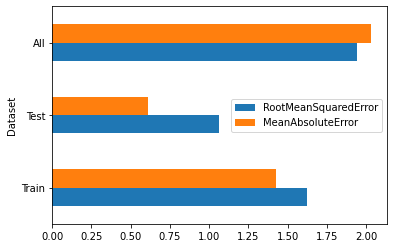

In [80]:
# Mỗi kết quả đánh giá (measures) trả về một mảng 2 chiều
# Thêm tên tập dữ liệu vào đầu mảng để mảng trở thành [Tên dataset, MSE, MAE]
# Đặt schema là các tên cột
plot_data = spark.createDataFrame(data= [['Train'] + measures_train,
                                         ['Test'] + measures,
                                         ['All'] + measures_all
                                        ]
                                  ,schema=['Dataset','RootMeanSquaredError','MeanAbsoluteError'])
plot_data.show()
plot_data.toPandas().plot.barh(x='Dataset')

## So sánh với thuật toán cung cấp sẵn bởi Spark

### Nhập thư viện

In [81]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lit

### Biến đổi dữ liệu

In [82]:
assembler = VectorAssembler(
    inputCols=df_train.columns, # Lấy toàn bộ các cột của df_train
    outputCol="features")

train_data = assembler.transform(df_train)
test_data = assembler.transform(df_test)
all_data = assembler.transform(df_modelData)

train_data.show()

+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+--------------------+
|Daysforshipping_real_|Daysforshipment_scheduled_|encodedShippingMode|Late_delivery_risk|encodedDeliveryStatus|order_hour|encodedOrderStatus|            features|
+---------------------+--------------------------+-------------------+------------------+---------------------+----------+------------------+--------------------+
|                    0|                         0|                  1|                 0|                    2|         1|                 8|[0.0,0.0,1.0,0.0,...|
|                    0|                         0|                  1|                 0|                    2|         1|                 8|[0.0,0.0,1.0,0.0,...|
|                    0|                         0|                  1|                 0|                    2|         1|                 8|[0.0,0.0,1.0,0.0,...|
|                    0

### Train model và đưa ra các đánh giá

[1.2850845226191394, 1.1287580055590014]
[1.2878022926257577, 1.1287580055590014]
[1.2878022926257577, 1.1293603554503175]
+-------+--------------------+------------------+------------------+------------------+
|Dataset|RootMeanSquaredError| MeanAbsoluteError|        ManualRMSE|         ManualMAE|
+-------+--------------------+------------------+------------------+------------------+
|  Train|  1.2850845226191394|1.1287580055590014|1.6226447554984775|1.4235989494286962|
|   Test|  1.2878022926257577|1.1287580055590014|1.0625738853225546| 0.608005963281564|
|    All|  1.2878022926257577|1.1293603554503175|1.9395977068237946| 2.031604912710266|
+-------+--------------------+------------------+------------------+------------------+



<AxesSubplot:ylabel='Dataset'>

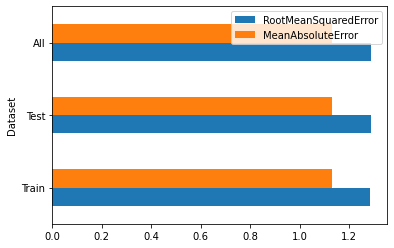

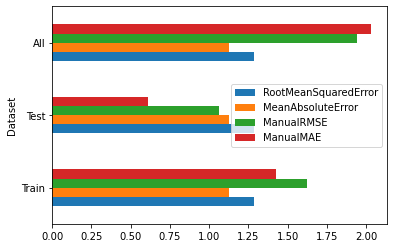

In [84]:
lr = LinearRegression(regParam=10.0, solver="normal",featuresCol="features",
                      labelCol="Daysforshipping_real_", predictionCol="y_pred")

lr_model = lr.fit(train_data)

test_predictions = lr_model.transform(test_data)
train_predictions = lr_model.transform(train_data)
all_predictions = lr_model.transform(test_data)

mse_evaluator = RegressionEvaluator(labelCol="Daysforshipping_real_", predictionCol="y_pred", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="Daysforshipping_real_", predictionCol="y_pred", metricName="mae")
# Lấy RMSE và MAE đối với mỗi tập dự đoán
ml_measures_test = [mse_evaluator.evaluate(test_predictions), mae_evaluator.evaluate(train_predictions)] 
ml_measures_train = [mse_evaluator.evaluate(train_predictions), mae_evaluator.evaluate(train_predictions)]
ml_measures_all = [mse_evaluator.evaluate(all_predictions), mae_evaluator.evaluate(all_predictions)]

print(ml_measures_train)
print(ml_measures_test)
print(ml_measures_all)
#Plot kết quả kiểm định của model
plot_data = spark.createDataFrame(data= [['Train'] + ml_measures_train,
                                         ['Test'] + ml_measures_test,
                                         ['All'] + ml_measures_all
                                        ]
                                  ,schema=['Dataset','RootMeanSquaredError','MeanAbsoluteError'])
plot_data.toPandas().plot.barh(x='Dataset')
# Tạo plot để so sánh với model tự thực hiện
# Manual tượng trưng cho model tự thực hiện
plot_data = spark.createDataFrame(data= [['Train'] + ml_measures_train + measures_train,
                                         ['Test'] + ml_measures_test + measures,
                                         ['All'] + ml_measures_all + measures_all,
                                        ]
                                  ,schema=[
                                      'Dataset','RootMeanSquaredError',
                                      'MeanAbsoluteError','ManualRMSE',
                                      'ManualMAE'])

plot_data.show()
plot_data.toPandas().plot.barh(x='Dataset')